In [1]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from scipy.stats import norm

Best so far: "!V:VarTransform=P,D:NTrees=4000:BoostType=Grad:Shrinkage=0.1:MaxDepth=3:SeparationType=GiniIndex:nCuts=20:UseRandomisedTrees:UseNvars=8:UseBaggedBoost:BaggedSampleFraction=0.6:PruneMethod=CostComplexity:PruneStrength=60"

A lot of trees > 3000
play with:
    BoostType
    shrinkage
    maxdepth
    ncuts
    usenvars
    baggedsamplefraction

RMS test: 8.00

20497 trees: 10.583min: 32 trees/sec

In [3]:
def getModels(numberModels = 10, letter = "A"):
    models = []
    ntrees = 0
    for modNumber in range(numberModels):
        s = "factory.BookMethod(dataloader, TMVA::Types::kBDT, "
        #name = "BDTG_" + letter + "_" + str(modNumber)
        name = 'Form("BDTG_' + letter + '_' + str(modNumber) + '_%d", testSet)'
        options = "!V"
        #varChoice = np.random.choice(getVarTransform(maxSymbols=2))
        varChoice = getVarTransformChoice(maxSymbols=4)
        if varChoice != "":
            options += ":VarTransform=" + varChoice
        t = getNTreesChoice(200, 3000)
        ntrees += t
        options += ":NTrees=" + str(t)
        #options += ":NTrees=" + "500"
        options += ":BoostType=" + np.random.choice(getBoostType())
        #options += ":BoostType=" + "Grad"
        options += ":Shrinkage=" + str(getShrinkageChoice(0.0, 1.0))
        #options += ":Shrinkage=" + "0.1"
        options += ":MaxDepth=" + str(getMaxDepthChoice(4, 8))
        #options += ":MaxDepth=" + "3"
        options += ":SeparationType=" + np.random.choice(getSeparationType())
        #options += ":SeparationType=" + "GiniIndex"
        options += ":nCuts=" + str(getNCutsChoice(1, 100))
        #options += ":nCuts=" + "20"
        options += ":UseRandomisedTrees=T"
        options += ":UseNvars=" + str(getUseNvarsChoice(1, 100))
        #options += ":UseNvars=" + "8"
        options += ":UseBaggedBoost"
        options += ":BaggedSampleFraction=" + str(getBaggedSampleFractionChoice(0.1, 5.0))
        #options += ":BaggedSampleFraction=" + "0.6"
        options += ":PruneMethod=" + np.random.choice(getPruneMethod())
        options += ":PruneStrength=" + str(getPruneStrengthChoice(0, 100))
        options += ":PruningValFraction=" + str(getPruningValFractionChoice(0.0, 2.0))
        models.append(s + name + ",\n\t\"" + options + "\");")
    print(ntrees)
    return models


def getModelsVar(a):
    models = []
    ntrees = getBaggedSampleFraction(spacing=11)
    for modNumber in range(len(ntrees)):
        s = "factory.BookMethod(dataloader, TMVA::Types::kBDT, "
        name = "BDTG_" + str(modNumber)
        options = "!V"
        #varChoice = np.random.choice(getBestVarTransform(5))
        varChoice = "P,N,D"
        if varChoice != "":
            options += ":VarTransform=" + varChoice
        #options += ":NTrees=" + str(np.random.choice(getNTrees()))
        options += ":NTrees=" + "100"
        #options += ":BoostType=" + np.random.choice(getBoostType())
        options += ":BoostType=" + "Grad"
        #options += ":Shrinkage=" + str(np.random.choice(getShrinkage()))
        options += ":Shrinkage=" + "0.32"
        #options += ":MaxDepth=" + str(np.random.choice(getMaxDepth()))
        options += ":MaxDepth=" + "6"
        #options += ":SeparationType=" + np.random.choice(getSeparationType())
        options += ":SeparationType=" + "GiniIndex"
        #options += ":nCuts=" + str(np.random.choice(getNCuts()))
        options += ":nCuts=" + "30"
        options += ":UseRandomisedTrees"
        #options += ":UseNvars=" + str(np.random.choice(getUseNvars()))
        options += ":UseNvars=" + "20"
        options += ":UseBaggedBoost"
        #options += ":BaggedSampleFraction=" + str(np.random.choice(getBaggedSampleFraction()))
        options += ":BaggedSampleFraction=" + str(ntrees[modNumber])
        options += ":PruneMethod=NoPruning"
        models.append(s + "\"" + name + "\",\n\t\"" + options + "\");")
    return models


def getVarTransform(minSymbols=0, maxSymbols=2):
    varTransform = ["P", "G", "D", "N"]
    good = []
    for repeatNum in range(minSymbols, maxSymbols + 1):
        initList = list(product(varTransform, repeat=repeatNum))
        for e in initList:
            repeated = False
            for i in range(len(e)-1):
                if e[i] == e[i+1]:
                    repeated = True
            if e.count("P") > 1:
                repeated = True
            if not repeated:
                good.append(",".join(e))
    return good


def getVarTransformChoice(minSymbols=0, maxSymbols=2):
    nTsf = np.random.randint(minSymbols, maxSymbols+1)
    varTransform = ["P", "G", "D", "N"]
    good = []
    initList = list(product(varTransform, repeat=nTsf))
    for e in initList:
        repeated = False
        for i in range(len(e)-1):
            if e[i] == e[i+1]:
                repeated = True
        if e.count("P") > 1:
            repeated = True
        if not repeated:
            good.append(",".join(e))
    return np.random.choice(good)


def getBestVarTransform(n=30):
    best = ["G", "N,G,N,G", "", "N", "P,N,D", "P,N,D,N", "P,G", "P,N", "P,D", "P", "N,G", "G,N", "G,N,G,N", "N,G,N", "G,N,G", "P,D,N", "P,D,N,D", "N,P,D", "N,P,N,D", "N,P,G", "P,D,G", "D,N,D", "P,G,N", "P,N,G", "D,N,G", "P,G,N,G", "D", "P,N,P,D"]
    return best[:n]


def getNTreesChoice(minNum = 100, maxNum=5000):
    return np.random.randint(minNum, maxNum+1)


def getBoostType():
    old = ["AdaBoost", "RealAdaBoost", "Bagging", "AdaBoostR2", "Grad"]
    return ["Grad"]


def getShrinkageChoice(minNum = 0.0, maxNum=1.0):
    return np.round(np.random.uniform(minNum, maxNum), 5)


def getMaxDepthChoice(minNum = 4, maxNum=8):
    return np.random.randint(minNum, maxNum+1)


def getSeparationType():
    return ["CrossEntropy", "GiniIndex", "GiniIndexWithLaplace", "MisClassificationError", "SDivSqrtSPlusB", "RegressionVariance"]


def getPruneMethod():
    all =  ["NoPruning", "ExpectedError", "CostComplexity"]
    return ["NoPruning"]


def getNCutsChoice(minNum = 1, maxNum=100):
    return np.random.randint(minNum, maxNum+1)


def getUseNvarsChoice(minNum = 1, maxNum=100):
    return np.random.randint(minNum, maxNum+1)


def getBaggedSampleFractionChoice(minNum = 0.1, maxNum=5.0):
    return np.round(np.random.uniform(minNum, maxNum), 5)


def getPruneStrengthChoice(minNum = 0, maxNum=100):
    return np.random.randint(minNum, maxNum+1)


def getPruningValFractionChoice(minNum = 0.0, maxNum=2.0):
    return np.round(np.random.uniform(minNum, maxNum), 5)

In [4]:
m = getModels(10, letter="P")

for i in m:
    print(i)

16253
factory.BookMethod(dataloader, TMVA::Types::kBDT, Form("BDTG_P_0_%d", testSet),
	"!V:NTrees=2594:BoostType=Grad:Shrinkage=0.62164:MaxDepth=8:SeparationType=RegressionVariance:nCuts=8:UseRandomisedTrees=T:UseNvars=49:UseBaggedBoost:BaggedSampleFraction=2.40753:PruneMethod=NoPruning:PruneStrength=4:PruningValFraction=1.10284");
factory.BookMethod(dataloader, TMVA::Types::kBDT, Form("BDTG_P_1_%d", testSet),
	"!V:VarTransform=D:NTrees=707:BoostType=Grad:Shrinkage=0.46161:MaxDepth=4:SeparationType=CrossEntropy:nCuts=17:UseRandomisedTrees=T:UseNvars=87:UseBaggedBoost:BaggedSampleFraction=1.22899:PruneMethod=NoPruning:PruneStrength=70:PruningValFraction=0.11708");
factory.BookMethod(dataloader, TMVA::Types::kBDT, Form("BDTG_P_2_%d", testSet),
	"!V:VarTransform=D,N,P,D:NTrees=2167:BoostType=Grad:Shrinkage=0.41112:MaxDepth=4:SeparationType=CrossEntropy:nCuts=37:UseRandomisedTrees=T:UseNvars=27:UseBaggedBoost:BaggedSampleFraction=0.89069:PruneMethod=NoPruning:PruneStrength=28:PruningValFra

In [5]:
def readModelsString():
    path = "tmva_models/models.txt"
    with open(path, 'r') as file:
        content = file.read()
        if len(content) > 0:
            return content
        raise Exception("Empty file: {}".format(path))


def readRMSsString(num = 0):
    path = "tmva_models/rms{}.txt".format(num)
    with open(path, 'r') as file:
        content = file.read()
        if len(content) > 0:
            return content
        raise Exception("Empty file: {}".format(path))


def getModelsInfo(models):
    infos = {}
    print(models.split(';')[0].split('"')[3].split(':'))
    for m in models.split(';')[:-1]:
        nameModel = m.split('"')[1][:-3]        
        optionsModel = []
        options = m.split('"')[3].split(':')
        if "VarTransform" in options[1]:
            optionsModel.append(options[1].split('=')[1])
            options = options[2:]
        else:
            optionsModel.append("")
            options = options[1:]
        optionsModel.append(int(options[0].split('=')[1]))
        optionsModel.append(options[1].split('=')[1])
        optionsModel.append(float(options[2].split('=')[1]))
        optionsModel.append(int(options[3].split('=')[1]))
        optionsModel.append(options[4].split('=')[1])
        optionsModel.append(int(options[5].split('=')[1]))
        optionsModel.append(options[6].split('=')[1])
        optionsModel.append(int(options[7].split('=')[1]))
        optionsModel.append(float(options[9].split('=')[1]))
        if options[10].split('=')[1] == "NoPruning":
            optionsModel.append(options[10].split('=')[1])
            optionsModel.append(int(0))
            optionsModel.append(float(0))
        else:
            optionsModel.append(options[10].split('=')[1])
            optionsModel.append(int(options[11].split('=')[1]))
            optionsModel.append(float(options[12].split('=')[1]))
        infos[nameModel] = optionsModel
    return infos


def fromDictToList(d):
    outList = []
    for key, value in d.items():
        outList.append([key] + value)
    return outList


def getModelsRMS(allRMS):
    allRMS = allRMS.replace(":", " ").replace("-", " ")
    RMS = {}
    for row in allRMS.split("\n"):
        #print(row.split())
        if len(row) > 0:
            RMS[row.split()[-8][:-2]] = float(row.split()[-5])
    return RMS


def concatenateInfoRMS(infos, rms0, rms1, rms2):
    agg = {}
    for k in infos.keys():
        agg[k] = infos[k] + [rms0[k]] + [rms1[k]] + [rms2[k]]
    return agg

In [10]:
# Read models and convert to dictionary
mread = readModelsString()
infs = getModelsInfo(mread)
print(len(infs))
# Read RMS's of the three samples and convert to dictionary
sread0, sread1, sread2 = readRMSsString(0), readRMSsString(1), readRMSsString(2)
rms0, rms1, rms2 = getModelsRMS(sread0), getModelsRMS(sread1), getModelsRMS(sread2)
print(len(rms0), len(rms1), len(rms2))
# Aggregate models to rms
agg_list = fromDictToList(concatenateInfoRMS(infs, rms0, rms1, rms2))
print(len(agg_list), len(agg_list[0]))

['!V', 'VarTransform=D', 'NTrees=976', 'BoostType=Bagging', 'Shrinkage=0.73374', 'MaxDepth=4', 'SeparationType=MisClassificationError', 'nCuts=21', 'UseRandomisedTrees=T', 'UseNvars=44', 'UseBaggedBoost', 'BaggedSampleFraction=1.51131', 'PruneMethod=NoPruning']
890
890 890 890
890 17


In [11]:
df = pd.DataFrame(agg_list, columns=["Model_name", "VarTransform", "NTrees", "BoostType", "Shrinkage", "MaxDepth", "SeparationType", "nCuts", "UseRandomisedTrees", "UseNvars", "BaggedFraction", "PruneMethod", "PruneStrength", "PruningValFraction", "RMS0", "RMS1", "RMS2"])
df["RMS"] = df[['RMS0', 'RMS1', 'RMS2']].mean(axis=1)

df = df[(df["RMS"].notna()) & (df["RMS"] < 18) & (df["BoostType"] == "Grad") & (df["MaxDepth"] < 9)]
# Define intervals of continuous variables
intervals_Shrinkage = np.linspace(df["Shrinkage"].min(), df["Shrinkage"].max(), 16)
df['BinShrinkage'] = pd.cut(df['Shrinkage'], bins=intervals_Shrinkage, labels = (intervals_Shrinkage[:-1]+intervals_Shrinkage[1:])/2, include_lowest=True)
intervals_nCuts = np.linspace(df["nCuts"].min(), df["nCuts"].max(), 16)
df['BinnCuts'] = pd.cut(df['nCuts'], bins=intervals_nCuts, labels = (intervals_nCuts[:-1]+intervals_nCuts[1:])/2, include_lowest=True)
intervals_UseNvars = np.linspace(df["UseNvars"].min(), df["UseNvars"].max(), 16)
df['BinUseNvars'] = pd.cut(df['UseNvars'], bins=intervals_UseNvars, labels = (intervals_UseNvars[:-1]+intervals_UseNvars[1:])/2, include_lowest=True)
intervals_BaggedFraction = np.linspace(df["BaggedFraction"].min(), df["BaggedFraction"].max(), 16)
df['BinBaggedFraction'] = pd.cut(df['BaggedFraction'], bins=intervals_BaggedFraction, labels = (intervals_BaggedFraction[:-1]+intervals_BaggedFraction[1:])/2, include_lowest=True)
intervals_NTrees = np.linspace(df["NTrees"].min(), df["NTrees"].max(), 16)
df['BinNTrees'] = pd.cut(df['NTrees'], bins=intervals_NTrees, labels = (intervals_NTrees[:-1]+intervals_NTrees[1:])/2, include_lowest=True)

# Add metrics of the transformations
df["nTransf"] = df["VarTransform"].apply(lambda x: int((len(x)+1)/2))
df["firstTransf"] = df["VarTransform"].apply(lambda x: x[0] if len(x)>0 else 'X')
df["lastTransf"] = df["VarTransform"].apply(lambda x: x[-1] if len(x)>0 else 'X')

#df = df[(df["NTrees"] > 100) & (df["Shrinkage"] < 0.4) & (df["Shrinkage"] > 0.05)]

display(df)

,Model_name,VarTransform,NTrees,BoostType,Shrinkage,MaxDepth,SeparationType,nCuts,UseRandomisedTrees,UseNvars,...,RMS2,RMS,BinShrinkage,BinnCuts,BinUseNvars,BinBaggedFraction,BinNTrees,nTransf,firstTransf,lastTransf
2,BDTG_A_2,,573,Grad,0.50645,6,GiniIndexWithLaplace,33,T,42,...,8.10,8.443333,0.500295,31.400000,43.466667,0.603076,537.666667,0,X,X
9,BDTG_B_4,"G,D,N,P",174,Grad,0.67673,4,GiniIndex,45,T,16,...,10.90,10.590000,0.698921,44.466667,17.333333,0.603076,147.533333,4,G,P
10,BDTG_B_5,G,195,Grad,0.85929,5,GiniIndex,45,T,17,...,8.40,8.826667,0.831338,44.466667,17.333333,1.538988,147.533333,1,G,G
15,BDTG_C_0,,260,Grad,0.91289,6,MisClassificationError,34,T,46,...,9.16,9.160000,0.897547,31.400000,43.466667,1.227017,342.600000,0,X,X
19,BDTG_C_4,"N,G,P,G",243,Grad,0.40945,4,MisClassificationError,34,T,17,...,8.50,9.190000,0.434086,31.400000,17.333333,0.603076,147.533333,4,N,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,BDTG_P_5,,1556,Grad,0.35049,6,RegressionVariance,61,T,28,...,7.26,7.620000,0.367878,64.066667,30.400000,4.346724,1513.000000,0,X,X
886,BDTG_P_6,"N,P",722,Grad,0.41525,7,GiniIndex,63,T,42,...,7.58,8.233333,0.434086,64.066667,43.466667,3.098841,732.733333,2,N,P
887,BDTG_P_7,,2976,Grad,0.16588,4,CrossEntropy,30,T,85,...,7.15,7.570000,0.169252,31.400000,82.666667,3.722783,2878.466667,0,X,X
888,BDTG_P_8,"D,G,N,G",1201,Grad,0.17421,4,RegressionVariance,31,T,81,...,7.88,8.220000,0.169252,31.400000,82.666667,3.410812,1122.866667,4,D,G


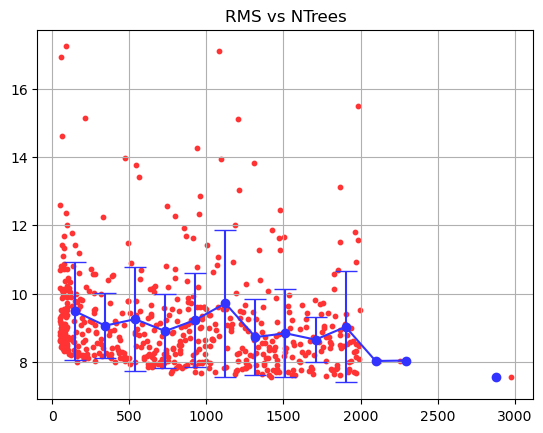

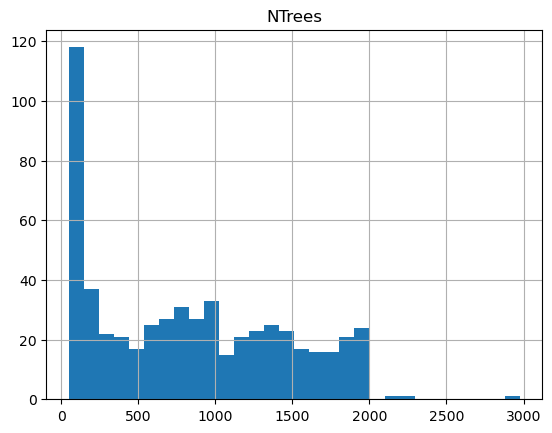

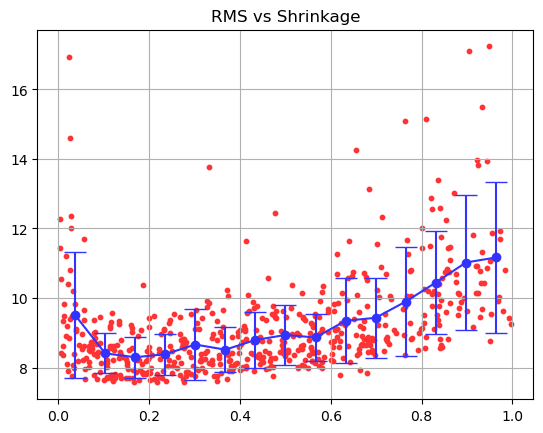

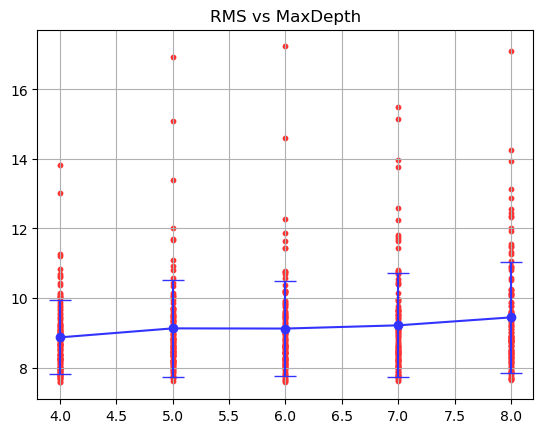

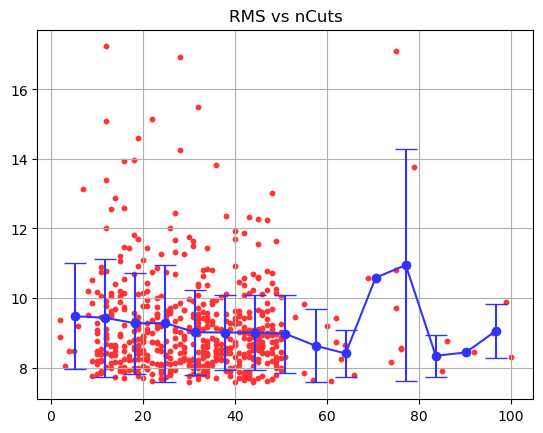

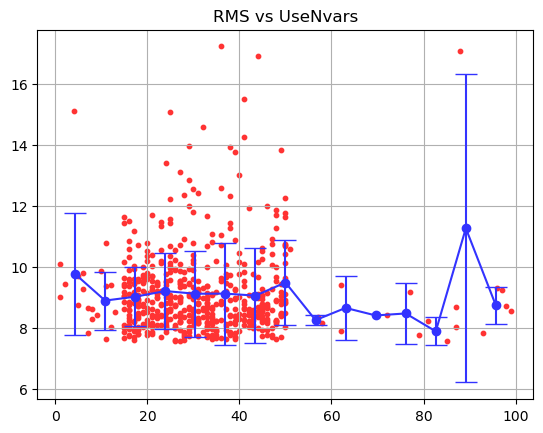

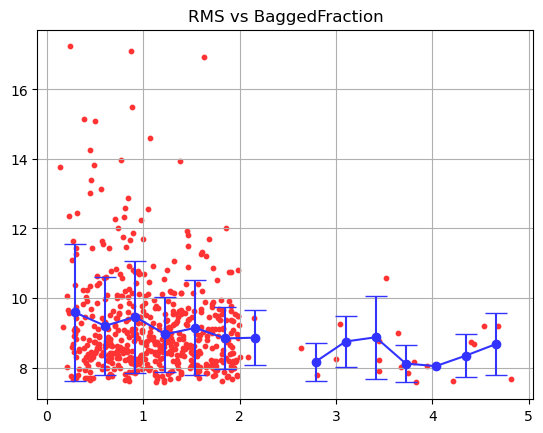

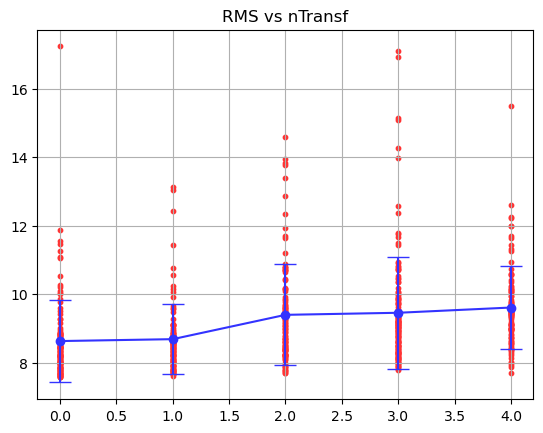

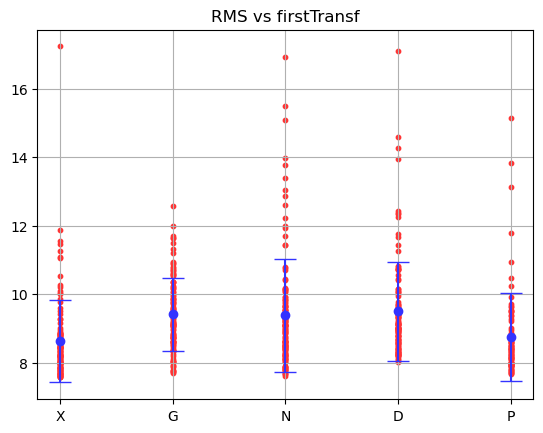

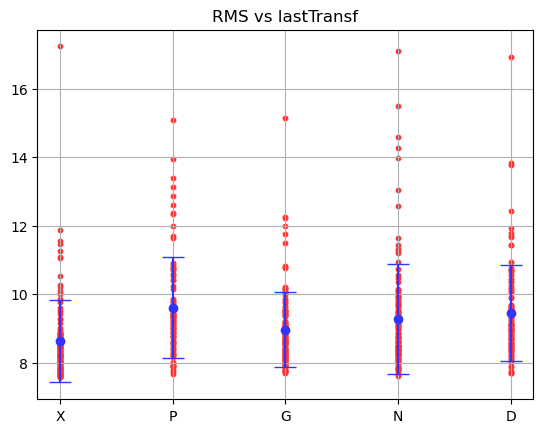

'plt.scatter(df["VarTransform"], df["RMS"], s=10, color="#ff3333")\nplt.errorbar(list(df.groupby(\'VarTransform\').groups.keys()), df.groupby(\'VarTransform\')[\'RMS\'].mean().to_numpy(), df.groupby(\'VarTransform\')[\'RMS\'].std().to_numpy(), fmt=\'o\', color="#3333ff", capsize=8)\nplt.title("RMS vs VarTransform")\nplt.xticks(rotation=90)\nplt.show()'

In [12]:
plt.scatter(df["NTrees"], df["RMS"], s=10, color="#ff3333")
plt.errorbar(list(df.groupby('BinNTrees').groups.keys()), df.groupby('BinNTrees')['RMS'].mean().to_numpy(), df.groupby('BinNTrees')['RMS'].std().to_numpy(), fmt='-o', color="#3333ff", capsize=8)
plt.title("RMS vs NTrees")
plt.grid()
plt.show()

plt.hist(df["NTrees"], bins=30)
plt.title("NTrees")
plt.grid()
plt.show()


'''plt.scatter(df["BoostType"], df["RMS"], s=10, color="#ff3333")
plt.errorbar(list(df.groupby('BoostType').groups.keys()), df.groupby('BoostType')['RMS'].mean().to_numpy(), df.groupby('BoostType')['RMS'].std().to_numpy(), fmt='-o', color="#3333ff", capsize=8)
plt.title("RMS vs BoostType")
plt.grid()
plt.show()'''
'''
#print(df.groupby('BoostType')['RMS'].mean(), df.groupby('BoostType')['RMS'].std())
mean_bagging, mean_grad, std_bagging, std_grad = df.groupby('BoostType')['RMS'].mean()["Bagging"], df.groupby('BoostType')['RMS'].mean()["Grad"], df.groupby('BoostType')['RMS'].std()["Bagging"], df.groupby('BoostType')['RMS'].std()["Grad"]
#print(mean_bagging, mean_grad, std_bagging, std_grad)
plt.hist(df[df["BoostType"] == "Bagging"]["RMS"], bins=10, alpha=0.5, label='Bagging', density=True)
plt.hist(df[df["BoostType"] == "Grad"]["RMS"], bins=10, alpha=0.5, label='Grad', density=True)
x = np.linspace(7, 15, 100)
plt.plot(x, norm.pdf(x, mean_bagging, std_bagging), color='blue', label='Bagging')
plt.plot(x, norm.pdf(x, mean_grad, std_grad), color='orange', label='Grad')
plt.legend(loc='upper right')
plt.xlabel('RMS')
plt.ylabel('Frequency')
plt.title('Histogram of Two Distributions')
plt.grid()
plt.show()
print("Probability that RMS(Grad) < RMS(Bagging) = ", norm(mean_grad-mean_bagging, np.sqrt(std_bagging**2 + std_grad**2)).cdf(0.0))
'''
plt.scatter(df["Shrinkage"], df["RMS"], s=10, color="#ff3333")
plt.errorbar(list(df.groupby('BinShrinkage').groups.keys()), df.groupby('BinShrinkage')['RMS'].mean().to_numpy(), df.groupby('BinShrinkage')['RMS'].std().to_numpy(), fmt='-o', color="#3333ff", capsize=8)
plt.title("RMS vs Shrinkage")
plt.grid()
plt.show()

plt.scatter(df["MaxDepth"], df["RMS"], s=10, color="#ff3333")
plt.errorbar(list(df.groupby('MaxDepth').groups.keys()), df.groupby('MaxDepth')['RMS'].mean().to_numpy(), df.groupby('MaxDepth')['RMS'].std().to_numpy(), fmt='-o', color="#3333ff", capsize=8)
plt.title("RMS vs MaxDepth")
plt.grid()
plt.show()

'''plt.scatter(df["SeparationType"], df["RMS"], s=10, color="#ff3333")
plt.errorbar(list(df.groupby('SeparationType').groups.keys()), df.groupby('SeparationType')['RMS'].mean().to_numpy(), df.groupby('SeparationType')['RMS'].std().to_numpy(), fmt='o', color="#3333ff", capsize=8)
plt.title("RMS vs SeparationType")
plt.xticks(rotation=45)
plt.grid()
plt.show()'''

plt.scatter(df["nCuts"], df["RMS"], s=10, color="#ff3333")
plt.errorbar(list(df.groupby('BinnCuts').groups.keys()), df.groupby('BinnCuts')['RMS'].mean().to_numpy(), df.groupby('BinnCuts')['RMS'].std().to_numpy(), fmt='-o', color="#3333ff", capsize=8)
plt.title("RMS vs nCuts")
plt.grid()
plt.show()

plt.scatter(df["UseNvars"], df["RMS"], s=10, color="#ff3333")
plt.errorbar(list(df.groupby('BinUseNvars').groups.keys()), df.groupby('BinUseNvars')['RMS'].mean().to_numpy(), df.groupby('BinUseNvars')['RMS'].std().to_numpy(), fmt='-o', color="#3333ff", capsize=8)
plt.title("RMS vs UseNvars")
plt.grid()
plt.show()

plt.scatter(df["BaggedFraction"], df["RMS"], s=10, color="#ff3333")
plt.errorbar(list(df.groupby('BinBaggedFraction').groups.keys()), df.groupby('BinBaggedFraction')['RMS'].mean().to_numpy(), df.groupby('BinBaggedFraction')['RMS'].std().to_numpy(), fmt='-o', color="#3333ff", capsize=8)
plt.title("RMS vs BaggedFraction")
plt.grid()
plt.show()


plt.scatter(df["nTransf"], df["RMS"], s=10, color="#ff3333")
plt.errorbar(list(df.groupby('nTransf').groups.keys()), df.groupby('nTransf')['RMS'].mean().to_numpy(), df.groupby('nTransf')['RMS'].std().to_numpy(), fmt='-o', color="#3333ff", capsize=8)
plt.title("RMS vs nTransf")
plt.grid()
plt.show()


plt.scatter(df["firstTransf"], df["RMS"], s=10, color="#ff3333")
plt.errorbar(list(df.groupby('firstTransf').groups.keys()), df.groupby('firstTransf')['RMS'].mean().to_numpy(), df.groupby('firstTransf')['RMS'].std().to_numpy(), fmt='o', color="#3333ff", capsize=8)
plt.title("RMS vs firstTransf")
plt.grid()
plt.show()


plt.scatter(df["lastTransf"], df["RMS"], s=10, color="#ff3333")
plt.errorbar(list(df.groupby('lastTransf').groups.keys()), df.groupby('lastTransf')['RMS'].mean().to_numpy(), df.groupby('lastTransf')['RMS'].std().to_numpy(), fmt='o', color="#3333ff", capsize=8)
plt.title("RMS vs lastTransf")
plt.grid()
plt.show()

'''plt.scatter(df["VarTransform"], df["RMS"], s=10, color="#ff3333")
plt.errorbar(list(df.groupby('VarTransform').groups.keys()), df.groupby('VarTransform')['RMS'].mean().to_numpy(), df.groupby('VarTransform')['RMS'].std().to_numpy(), fmt='o', color="#3333ff", capsize=8)
plt.title("RMS vs VarTransform")
plt.xticks(rotation=90)
plt.show()'''



In [9]:

print(df.loc[df['RMS'].idxmin()])

Model_name            BDTG_I_120
VarTransform                    
NTrees                      1416
BoostType                   Grad
Shrinkage                0.21709
MaxDepth                       6
SeparationType         GiniIndex
nCuts                         40
UseRandomisedTrees             T
UseNvars                      27
BaggedFraction           1.12912
PruneMethod            NoPruning
PruneStrength                  0
PruningValFraction           0.0
RMS0                        8.43
RMS1                        7.15
RMS2                        7.13
RMS                         7.57
BinShrinkage             0.23546
BinnCuts               37.933333
BinUseNvars                 30.1
BinBaggedFraction       1.227017
BinNTrees                 1412.2
nTransf                        0
firstTransf                    X
lastTransf                     X
Name: 520, dtype: object
